Rank of the original image: 100
Took 0.03643298 seconds to perform QR decomposition
12.230005647307326


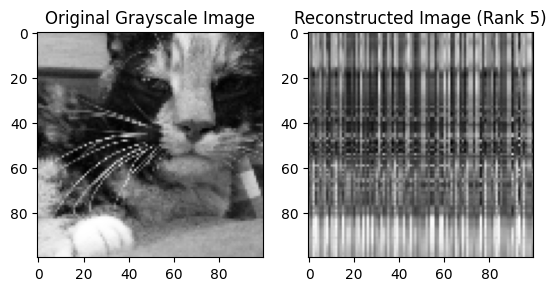

In [51]:
import imageio as iio
import numpy as np
from matplotlib import pyplot
from skimage import color
import time
from skimage.metrics import peak_signal_noise_ratio as psnr
import factorizations as fct
from PIL import Image
import cv2

# Load the image
image = iio.v3.imread('imageio:wikkie.png')

# Convert the image to grayscale
img_gray = color.rgb2gray(image)

img_gray = cv2.resize(img_gray, (100, 100))

original_rank = np.linalg.matrix_rank(img_gray)

print("Rank of the original image:", original_rank)

# Perform QR decomposition
start_qr_time = time.time()

A = img_gray

def householder_reflection(a):
    """Create the Householder matrix that will zero out the sub-diagonal elements of matrix a."""
    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    v = v / np.linalg.norm(v)
    H = np.eye(len(a)) - 2 * np.outer(v, v)
    return H

m, n = A.shape
Q = np.eye(m)
R = A.copy()
P = np.eye(n)

for i in range(min(m, n)):
    # Pivoting based on the maximum norm of remaining columns
    max_col = np.argmax(np.linalg.norm(R[i:, i:], axis=0)) + i
    P[:, [i, max_col]] = P[:, [max_col, i]]
    R[:, [i, max_col]] = R[:, [max_col, i]]

    # Apply Householder reflection
    H = np.eye(m)
    H[i:, i:] = householder_reflection(R[i:, i])
    R = np.dot(H, R)
    Q = np.dot(Q, H.T)

end_qr_time = time.time()

print('Took {:.8f} seconds to perform QR decomposition'.format(end_qr_time - start_qr_time))

rank = 5

# Apply permutation matrix to R before truncating
R_permuted = R @ P

# Truncate Q and the permuted R to the chosen rank
Q_truncated = Q[:, :rank]
R_truncated = R_permuted[:rank, :]

# Reconstruct the image using the truncated matrices
img_reconstructed = Q_truncated @ R_truncated

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img_gray, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(rank))

print(psnr(img_gray, img_reconstructed))

pyplot.show()

SVD decomposition took 0.02566290 seconds
28.565075854437385


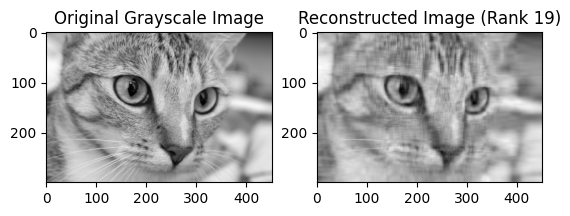

In [37]:
# Start timing for SVD decomposition
start_svd_time = time.time()

# Perform SVD decomposition
U, S, Vt = np.linalg.svd(img_gray, full_matrices=False)

end_svd_time = time.time()
print("SVD decomposition took {:.8f} seconds".format(end_svd_time - start_svd_time))

rank = 19

# Use only the top 'rank' singular values and corresponding vectors
U_truncated = U[:, :rank]
S_truncated = np.diag(S[:rank])
Vt_truncated = Vt[:rank, :]

# Reconstruct the image using the truncated matrices
img_reconstructed = U_truncated @ S_truncated @ Vt_truncated

# Display the original grayscale image
pyplot.subplot(1, 2, 1)
pyplot.imshow(img_gray, cmap=pyplot.cm.gray)
pyplot.title('Original Grayscale Image')

# Display the reconstructed image
pyplot.subplot(1, 2, 2)
pyplot.imshow(img_reconstructed, cmap=pyplot.cm.gray)
pyplot.title('Reconstructed Image (Rank {})'.format(rank))

print(psnr(img_gray, img_reconstructed))

pyplot.show()